In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
import mplfinance as mpf    
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [8]:
df_csv = pd.read_csv('伦敦布伦特原油期货历史数据(清洗).csv',encoding='gb2312')
df_csv.head()

,日期,收盘,开盘,高,低,交易量,涨跌幅
0,2021/12/20,71.52,72.82,72.87,69.28,333.76K,-0.0272
1,2021/12/21,73.98,71.88,74.27,71.24,214.07K,0.0344
2,2021/12/22,75.29,74.05,75.67,73.62,166.71K,0.0177
3,2021/12/23,76.85,75.47,77.00,74.78,161.24K,0.0207
4,2021/12/24,76.14,76.72,76.79,75.75,30.54K,-0.0092


In [9]:
data = df_csv
# 把日期类型转为datetime
data['日期'] = pd.to_datetime(data['日期'])

In [10]:
# 查看各变量的数据类型
data.dtypes

日期     datetime64[ns]
收盘            float64
开盘            float64
高             float64
低             float64
交易量            object
涨跌幅           float64
dtype: object

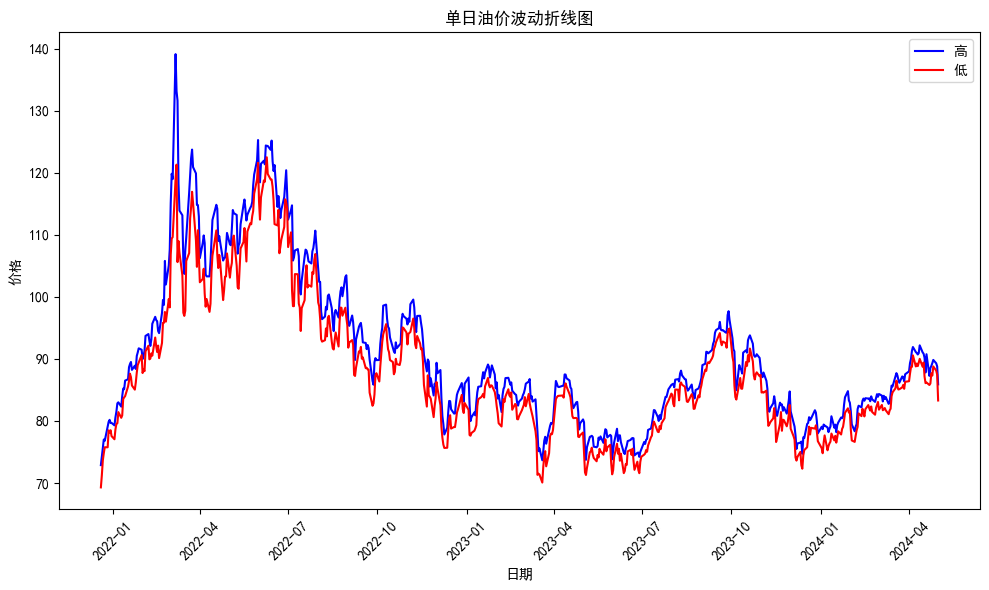

In [11]:
# 单日油价波动折线图

# 绘制
plt.figure(figsize=(10, 6))
plt.plot(data['日期'], data['高'], label='高', color='blue')
plt.plot(data['日期'], data['低'], label='低', color='red')
plt.xlabel('日期')
plt.ylabel('价格')
plt.title('单日油价波动折线图')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()


d:\python 3.80\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\python 3.80\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\python 3.80\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\python 3.80\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\python 3.80\lib\site-packages\statsmodels

                               SARIMAX Results                                
Dep. Variable:                     收盘   No. Observations:                  611
Model:                 ARIMA(0, 2, 2)   Log Likelihood               -1375.380
Date:                Mon, 20 May 2024   AIC                           2756.761
Time:                        23:34:43   BIC                           2769.996
Sample:                             0   HQIC                          2761.910
                                - 611                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9783      0.131     -7.493      0.000      -1.234      -0.722
ma.L2         -0.0215      0.039     -0.552      0.581      -0.098       0.055
sigma2         5.3056      0.681      7.785      0.0

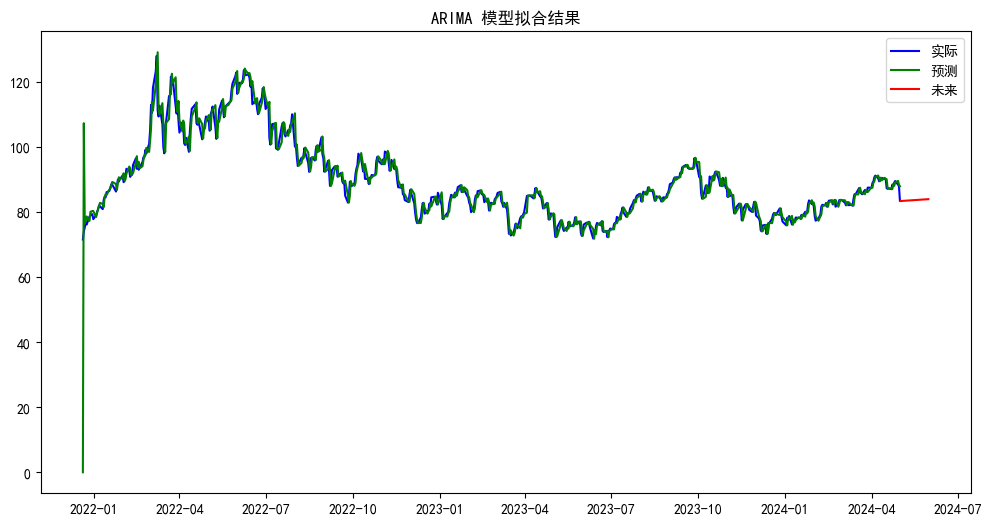

In [14]:
#基于时间序列模型(ARIMA模型)对未来油价价格(高)变化趋势的预测

# 设置日期为索引
# 跑一次够了，第二次跑会报错
# data.set_index('日期', inplace=True)

# 创建 ARIMA 模型
model = ARIMA(data['收盘'], order=(0,2,2)) #  MA(2) 二阶差分 详见ARIMA参数确定(石油)

# 拟合 ARIMA 模型
model_fit = model.fit()

# 打印概要
print(model_fit.summary())

# 进行未来价格预测
future_steps = 30  # 想更改预测天数改这里
forecast = model_fit.forecast(steps=future_steps)
print("未来价格预测值：", forecast)

# 创建未来日期序列
future_dates = pd.date_range(start=data.index[-1], periods=future_steps + 1, freq=data.index.freq)[1:]

# 绘制拟合图
plt.figure(figsize=(12, 6))
plt.plot(data['收盘'], color='blue', label='实际')
plt.plot(model_fit.fittedvalues, color='green', label='预测')
plt.plot(future_dates, forecast, color='red', label='未来')
plt.legend()
plt.title('ARIMA 模型拟合结果')
plt.show()

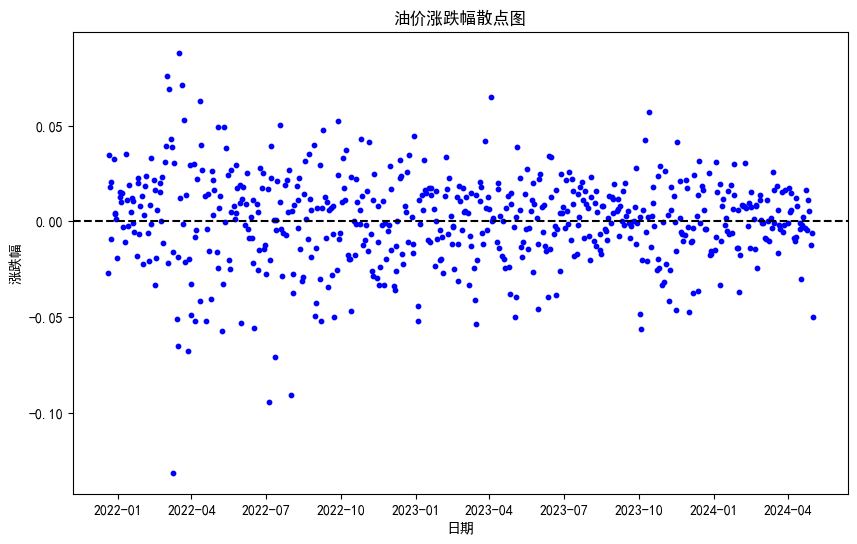

In [78]:
# 涨跌幅散点图
plt.figure(figsize=(10,6))
plt.scatter(data['日期'], data['涨跌幅'], color='b', marker='o', s=10)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('日期')
plt.ylabel('涨跌幅')
plt.title('油价涨跌幅散点图')
plt.show()

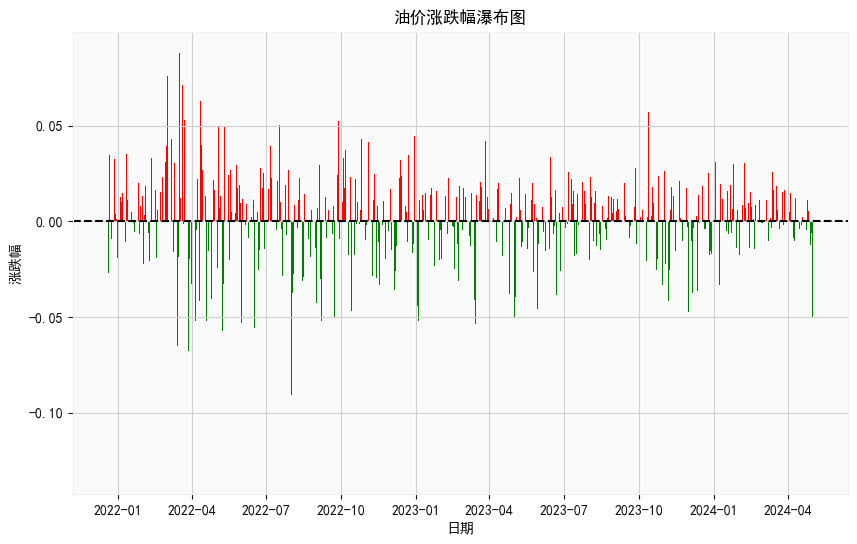

In [135]:
# 瀑布图
plt.figure(figsize=(10,6))
plt.bar(data['日期'], data['涨跌幅'], color=['r' if x >= 0 else 'g' for x in data['涨跌幅']], width=0.8)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('日期')
plt.ylabel('涨跌幅')
plt.title('油价涨跌幅瀑布图')
plt.show()

斜率 : -3.322365102274963e-06
截距 : 0.001877869445475492


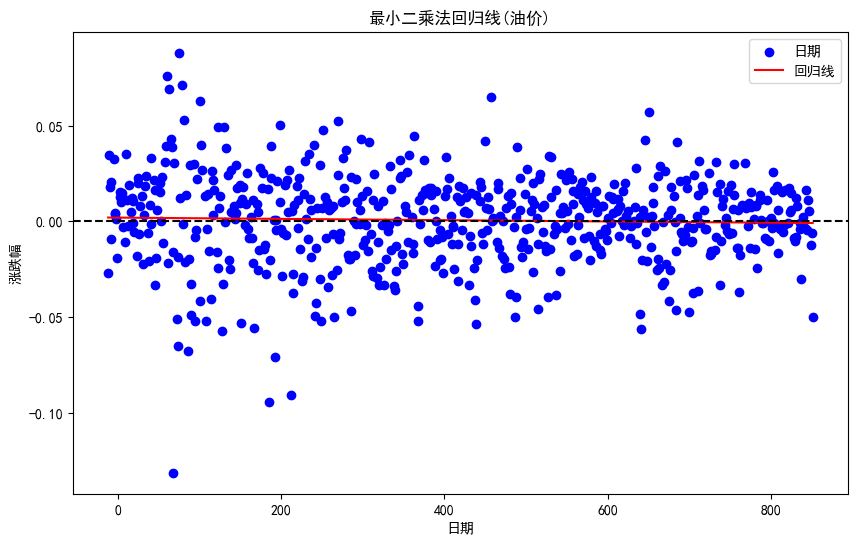

In [76]:
# 涨跌幅的最小二乘法线性回归分析

# 将日期转换为自某一固定日期以来的天数
# xy轴必须得是同类型的数据不然会报错
start_date = pd.Timestamp('2022-01-01')  
new_dates = (data['日期'] - start_date).dt.days.astype(float)

X = new_dates.values.reshape(-1, 1)  
y = data['涨跌幅'].values

# 创建模型
model = LinearRegression()

# 拟合模型
model.fit(X, y)

# 打印斜率与截距
slope = model.coef_[0]
intercept = model.intercept_
print("斜率 :", slope)
print("截距 :", intercept)

# 绘制散点图和回归线
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='b', marker='o', label='日期')
plt.plot(X, model.predict(X), color='r', label='回归线')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('日期')
plt.ylabel('涨跌幅')
plt.title('最小二乘法回归线(油价)')
plt.legend()
plt.show()

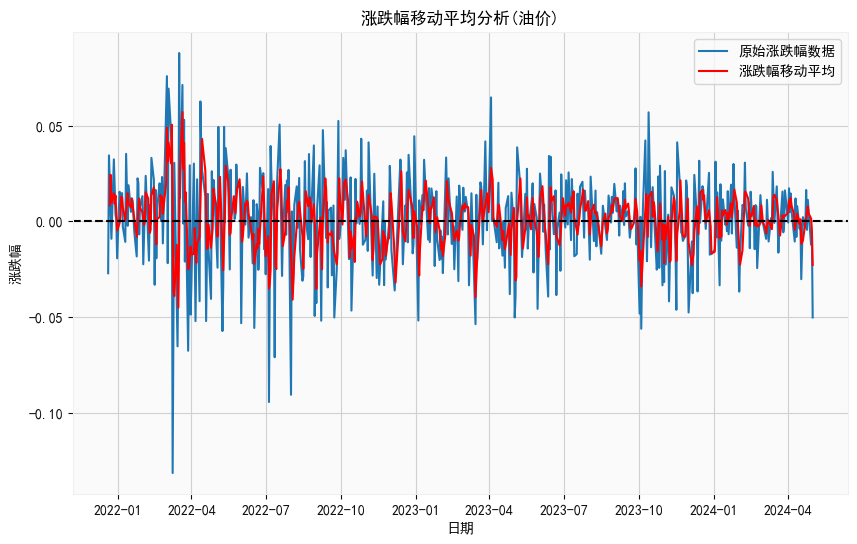

In [136]:
# 涨跌幅散点图的移动平均分析
window_size = 3 #改周期在这改
data['移动平均'] = data['涨跌幅'].rolling(window=window_size).mean()

#绘图
plt.figure(figsize=(10,6))
plt.plot(data['日期'], data['涨跌幅'], label='原始涨跌幅数据')
plt.plot(data['日期'], data['移动平均'], label='涨跌幅移动平均', color='red')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('日期')
plt.ylabel('涨跌幅')
plt.title('涨跌幅移动平均分析(油价)')
plt.legend()
plt.show()


In [117]:
# K线图的数据准备

# 日期做索引，跑一次
# data.set_index('日期', inplace=True)
# 截取的日期可以更改，范围是从2021.12.20至2024.5.1(不建议选太多)
oil=data['2021/12/21':'2023/01/20'][['开盘','高','低','收盘','交易量']]
# 改名，为了满足mpf的条件
oil = oil.rename(columns={'开盘': 'Open', '高': 'High', '低': 'Low', '收盘': 'Close', '交易量': 'Volume'})
# 去掉 'Volume' 列中的 'K' 单位并将其转换为 float 类型
oil['Volume'] = oil['Volume'].str.replace('K', '').astype(float) * 1000
oil



,Open,High,Low,Close,Volume
日期,,,,,
2021-12-21,71.88,74.27,71.24,73.98,214070.0
2021-12-22,74.05,75.67,73.62,75.29,166710.0
2021-12-23,75.47,77.00,74.78,76.85,161240.0
2021-12-24,76.72,76.79,75.75,76.14,30540.0
2021-12-27,76.32,79.08,75.75,78.60,85390.0
...,...,...,...,...,...
2023-01-16,85.36,85.59,83.83,84.46,125960.0
2023-01-17,84.20,86.82,84.04,85.92,238300.0
2023-01-18,86.45,87.85,84.36,84.98,288150.0


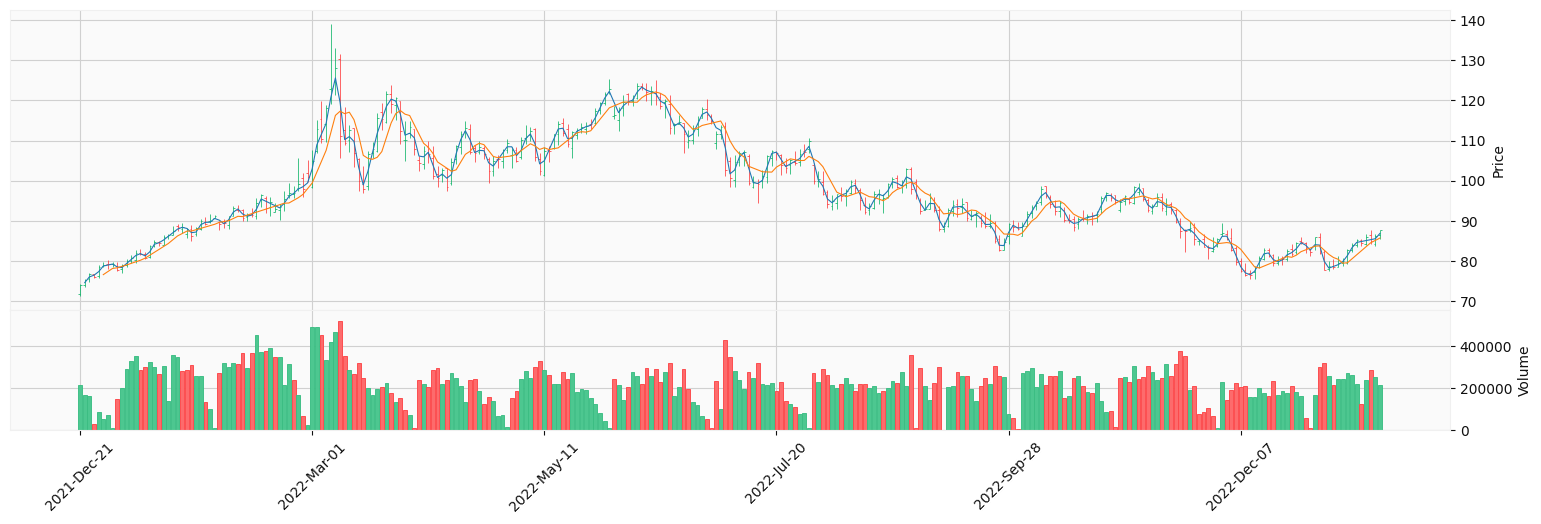

In [126]:
#ohlc图
# style='binance’,‘blueskies’,‘brasil’,‘charles’,‘checkers’,‘classic’,‘default’,‘mike’,‘nightclouds’,‘sas’,
#‘starsandstripes’,‘yahoo’，觉得主题不适合可以换
mpf.plot(oil, type='ohlc', figsize = (20,6), volume=True,
         style='yahoo',mav=(2,6))  

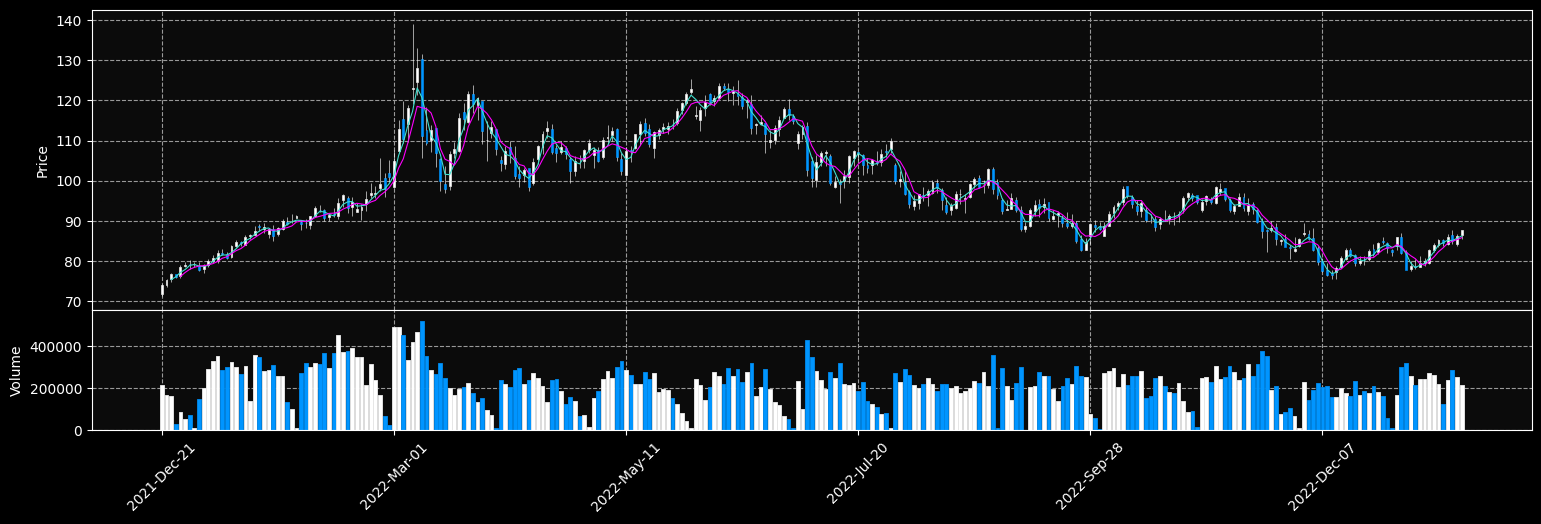

In [125]:
#candle图
mpf.plot(oil,type='candle', volume=True, mav=(3,5),
         figsize = (20,6),style='nightclouds')